<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/RiverWSE-Estimation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:

! pip install xee -q

In [ ]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.stats import gaussian_kde
import os
import re

In [ ]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

In [18]:
map=geemap.Map(basemap="SATELLITE")
map

Sorting by latitude (north-south cross-section).


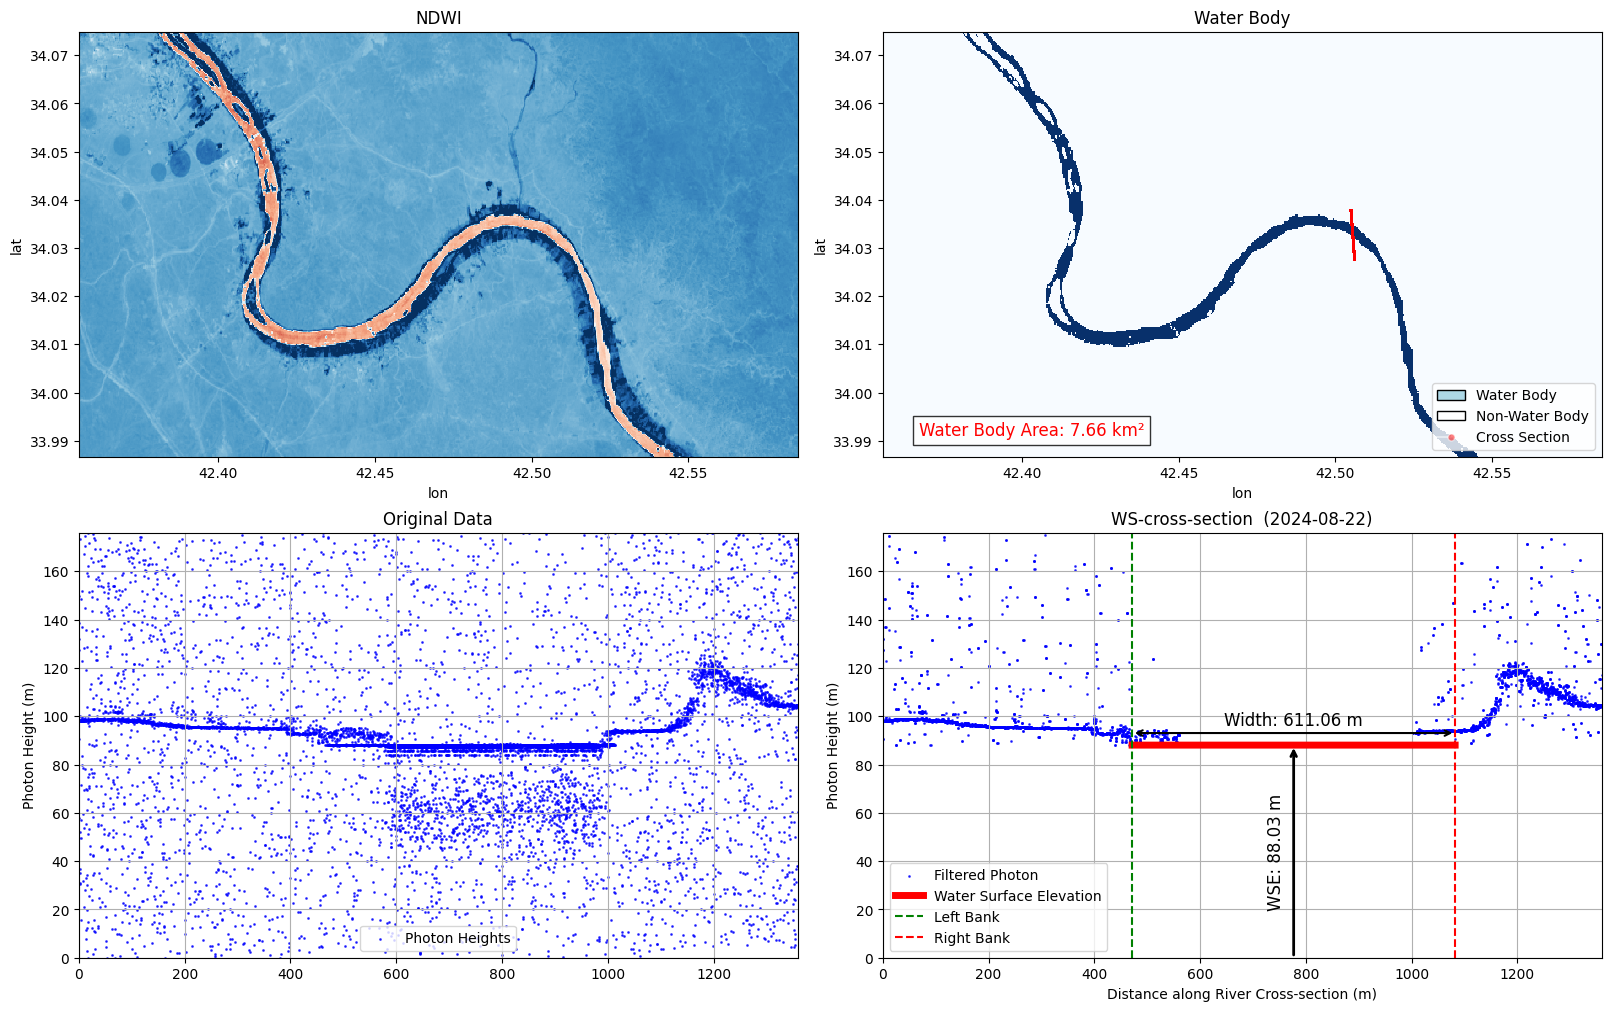

In [18]:
# ------------------------------ ROI & NDWI ------------------------------
roi = map.draw_last_feature.geometry()
start_time = '2020-01-01'
end_time = '2021-12-30'

landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(roi).filterDate(start_time, end_time)

def ndwi(img):
    qa = img.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 3).neq(0)
    cirrus = qa.bitwiseAnd(1 << 2).neq(0)
    shadow = qa.bitwiseAnd(1 << 4).neq(0)
    mask = cloud.Or(cirrus).Or(shadow)
    bands = img.select('SR.*').multiply(2.75e-05).add(-0.2)
    index = bands.normalizedDifference(['SR_B3', 'SR_B5']).rename('ndwi')
    return index.updateMask(mask.Not()).copyProperties(img, img.propertyNames())

landsat_ndwi = landsat.map(ndwi)

ds = xr.open_dataset(landsat_ndwi, engine='ee', crs='EPSG:4326', scale=0.000269, geometry=roi)
ds_mean = ds.mean('time')

from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=42)
df = ds_mean.to_dataframe()
df['clustering'] = model.fit_predict(df[['ndwi']])
xarr = df.to_xarray().sortby('lon').sortby('lat')

lake_pixels = (xarr.clustering == 1).sum().item()
lake_area_km2 = lake_pixels * 900 / 1_000_000  # each pixel = 900 m²

# ------------------------------ Hampel Filter ------------------------------
def hampel_filter(data, window_size=20, threshold=7):
    filtered_data = data.copy()
    half_window = window_size // 2
    for i in range(half_window, len(data) - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:
            continue
        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = median
    return filtered_data

# ------------------------------ Load ATL03 ------------------------------
Initial_file_path = '/content/photon_2024-08-22_t1005_1747988003125.csv'
df_initial = pd.read_csv(Initial_file_path)

filename = os.path.basename(Initial_file_path)
match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
Date = match.group() if match else "Unknown"

latitude = df_initial.iloc[:, 1].values
longitude = df_initial.iloc[:, 2].values
photon_height = df_initial.iloc[:, 3].values

lat_range = max(latitude) - min(latitude)
lon_range = max(longitude) - min(longitude)

if lat_range > lon_range:
    sorted_indices = np.argsort(latitude)
    print("Sorting by latitude (north-south cross-section).")
else:
    sorted_indices = np.argsort(longitude)
    print("Sorting by longitude (east-west cross-section).")

latitude = latitude[sorted_indices]
longitude = longitude[sorted_indices]
photon_height = photon_height[sorted_indices]

stronger_filtered_photon_height = hampel_filter(photon_height, window_size=20, threshold=7)
final_filtered_photon_height = medfilt(stronger_filtered_photon_height, kernel_size=5)

lat_to_meters = 111320
lon_to_meters = 40075000 * np.cos(np.radians(np.mean(latitude))) / 360
cross_section_distances = np.cumsum(
    np.sqrt(np.diff(latitude) ** 2 * lat_to_meters ** 2 + np.diff(longitude) ** 2 * lon_to_meters ** 2)
)
cross_section_distances = np.insert(cross_section_distances, 0, 0)

kde = gaussian_kde(final_filtered_photon_height, bw_method=0.2)
photon_height_range = np.linspace(min(final_filtered_photon_height), max(final_filtered_photon_height), 1000)
density_values = kde(photon_height_range)
peak_height = photon_height_range[np.argmax(density_values)]

water_surface_mask = (final_filtered_photon_height >= peak_height - 0.2) & (final_filtered_photon_height <= peak_height)
water_surface_heights = final_filtered_photon_height[water_surface_mask]
water_surface_distances = cross_section_distances[water_surface_mask]
average_water_surface_height = np.mean(water_surface_heights)

above_water_surface_mask = final_filtered_photon_height >= average_water_surface_height
filtered_above_water_surface_distances = cross_section_distances[above_water_surface_mask]
filtered_above_water_surface_heights = final_filtered_photon_height[above_water_surface_mask]

left_bank = np.percentile(water_surface_distances, 1)
right_bank = np.percentile(water_surface_distances, 99)
river_width_percentile = right_bank - left_bank

trimmed_mask = (cross_section_distances >= left_bank) & (cross_section_distances <= right_bank)
trimmed_distances = cross_section_distances[trimmed_mask]
trimmed_surface = np.full_like(trimmed_distances, average_water_surface_height)

# ------------------------------ Unified Plot ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)

# NDWI
ds_mean.ndwi.plot(ax=axs[0, 0], x='lon', y='lat', robust=True, add_colorbar=False)
axs[0, 0].set_title("NDWI")

# Clustering
xarr.clustering.plot(ax=axs[0, 1], x='lon', y='lat', cmap='Blues',add_colorbar=False)
axs[0, 1].set_title("Water Body")

# Add lake area annotation
axs[0, 1].text(0.05, 0.05, f"Water Body Area: {lake_area_km2:.2f} km²",
               transform=axs[0, 1].transAxes,
               fontsize=12, color='red',
               bbox=dict(facecolor='white', alpha=0.8))

# Overlay photon points
axs[0, 1].scatter(longitude, latitude, s=1, color='red', alpha=0.5, label='Photons')

# Add custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='lightblue', edgecolor='k', label='Water Body'),
    Patch(facecolor='white', edgecolor='k', label='Non-Water Body'),
    Line2D([0], [0], marker='o', color='w', label='Cross Section',
           markerfacecolor='red', markersize=5, alpha=0.5)
]

axs[0, 1].legend(handles=legend_elements, loc='lower right')


# Photon Original
axs[1, 0].scatter(cross_section_distances, photon_height, color='blue', s=1, alpha=0.7, label="Photon Heights")
axs[1, 0].set_title('Original Data')
axs[1, 0].set_ylabel("Photon Height (m)")
axs[1, 0].set_xlim(0, np.max(cross_section_distances))
axs[1, 0].set_ylim(0, average_water_surface_height + average_water_surface_height)

axs[1, 0].legend(loc='best')
axs[1, 0].grid(True)

# Filtered + WSE
axs[1, 1].scatter(filtered_above_water_surface_distances, filtered_above_water_surface_heights,
                 color='blue', s=1, alpha=0.7, label="Filtered Photon")
axs[1, 1].plot(trimmed_distances, trimmed_surface, color='red', linestyle='-', linewidth=5, label="Water Surface Elevation")
axs[1, 1].set_title(f'WS-cross-section  ({Date})')
axs[1, 1].set_xlabel("Distance along River Cross-section (m)")
axs[1, 1].set_ylabel("Photon Height (m)")
axs[1, 1].set_xlim(0, np.max(cross_section_distances))
axs[1, 1].set_ylim(0, average_water_surface_height + average_water_surface_height)
axs[1, 1].axvline(left_bank, color='green', linestyle='--', label='Left Bank')
axs[1, 1].axvline(right_bank, color='red', linestyle='--', label='Right Bank')

# Width annotation
axs[1, 1].annotate('', xy=(right_bank, average_water_surface_height + 5), xytext=(left_bank, average_water_surface_height + 5),
                  arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
axs[1, 1].text((left_bank + right_bank) / 2, average_water_surface_height + 8,
              f'Width: {river_width_percentile:.2f} m',
              horizontalalignment='center', fontsize=12, color='black')

# WSE annotation
center_of_river = (left_bank + right_bank) / 2
axs[1, 1].annotate('', xy=(center_of_river, average_water_surface_height), xytext=(center_of_river, 0),
                  arrowprops=dict(arrowstyle='->', color='black', lw=2))
axs[1, 1].text(center_of_river - 50, average_water_surface_height - 20,
              f'WSE: {average_water_surface_height:.2f} m',
              verticalalignment='top', fontsize=12, color='black', rotation=90)

axs[1, 1].grid(True)
axs[1, 1].legend(loc='best')

plt.show()
